# Deep learning 
---

The following notebook outlines the steps to setting up a deep learning program that can learn to differentiate between different types of images. 

This is an adaption of a deep learning module found within lesson two of the 'Deep learning for Coders' course. Originally this module was intended for differentiating between grizzly bears, brown bears and teddy bears, I've made some slight alterations to instead look at different breeds of dog. Additionally, this code involved using a bing image search to obtain the images, this has been changed to a duck duck go search for ease of use. I'd like to thank the author of the [following forum post](https://forums.fast.ai/t/chapter-2-using-duckduckgo-to-build-your-dataset/95872) for the code to alter this search.

In [2]:
#hide
from fastai.vision.widgets import *


## Gathering data

The following code cells are responsible for collecting images. We're scraping images of dogs, particularly pomeranians, huskys and bulldogs to serve as data for our model. 

In [3]:
# Download images of different bear categories
def download_images_ddg(img_category, img_types, num_images):
    if not path.exists():
        path.mkdir()
        for o in img_types:
            dest = (path/o)
            dest.mkdir(exist_ok=True)
            results = search_images_ddg(f'{str(o)} {img_category}', max_images=num_images)
            for u in range(len(results)):
                try:
                    download_url(url=results[u], 
                                 dest=f'{dest}/{str(o)}-{str(u+1)}.jpg', 
                                 timeout=400, 
                                 show_progress=False)
                except:
                    print(f'not found {results[u]}')
                    continue

The following two cells define our search parameters and download the requested images.

In [4]:
# Define image category and image types
img_category = 'dogs'
img_types = ['pomeranian','husky','bulldog']
path = Path(img_category)

In [5]:
download_images_ddg(img_category, img_types, num_images=200)

not found https://img.dogsnow.com/slir/w800/dogs/data/photos/272707/1596103723/white-pomeranian.jpg
not found http://www.zastavki.com/pictures/2560x1600/2011/Animals_Dogs_Pomeranian_spitz-dogs_029042_.jpg
not found http://www.zastavki.com/pictures/originals/2013/Animals___Dogs_Little_puppies_Siberian_Husky_048494_.jpg
not found http://www.zastavki.com/pictures/originals/2017Animals___Dogs_Little_funny_husky_puppies_118502_.jpg
not found https://dogsonlyclub.net/wp-content/uploads/2020/11/alaskan-husky-weight.jpg
not found http://www.zastavki.com/pictures/originals/2017Animals___Dogs_The_Husky_breed_dog_lies_with_a_sad_face_117029_.jpg
not found https://whitediamondenglishbulldogs.com/wp-content/uploads/2020/01/male-english-bulldog-.......-768x746.jpg
not found https://www.luxurypuppies2u.com/wp-content/uploads/2020/09/FullSizeR-22.jpg
not found https://www.classifieds.uk/wp-content/uploads/2021/03/English-Bulldog.jpg
not found https://www.luxurypuppies2u.com/wp-content/uploads/2020/11/

Here, we are checking for any images that may have failed to download and removing them so they don't interfere with the data set.

In [6]:
# Check for failed images
fns = get_image_files(path)
failed = verify_images(fns)
failed.map(Path.unlink);

In [7]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [8]:
fns = get_image_files(path)
fns

(#578) [Path('dogs/pomeranian/pomeranian-155.jpg'),Path('dogs/pomeranian/pomeranian-182.jpg'),Path('dogs/pomeranian/pomeranian-100.jpg'),Path('dogs/pomeranian/pomeranian-93.jpg'),Path('dogs/pomeranian/pomeranian-14.jpg'),Path('dogs/pomeranian/pomeranian-25.jpg'),Path('dogs/pomeranian/pomeranian-163.jpg'),Path('dogs/pomeranian/pomeranian-82.jpg'),Path('dogs/pomeranian/pomeranian-158.jpg'),Path('dogs/pomeranian/pomeranian-143.jpg')...]

In [9]:
failed = verify_images(fns)
failed

(#0) []

In [10]:
failed.map(Path.unlink);

In [11]:
dogs = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [12]:
#hide
dls = dogs.dataloaders(path)

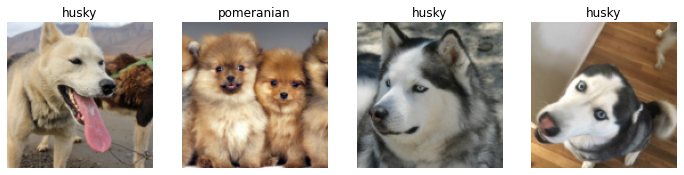

In [13]:
#hide
dls.valid.show_batch(max_n=4, nrows=1)

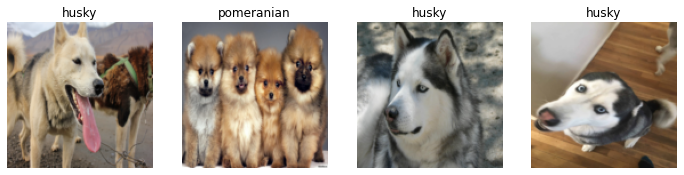

In [14]:
#hide
dogs = dogs.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = dogs.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

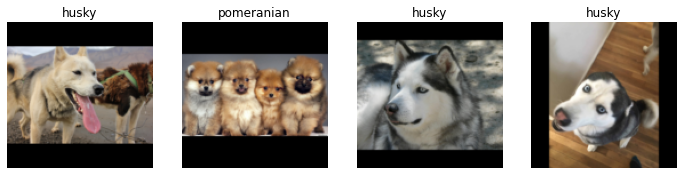

In [15]:
#hide
dogs = dogs.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = dogs.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

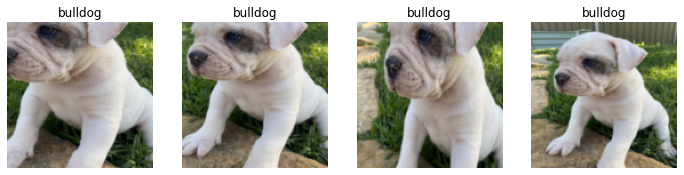

In [16]:
#hide
dogs = dogs.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = dogs.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

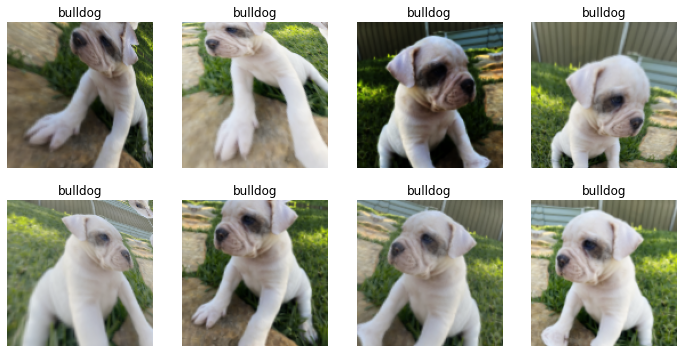

In [17]:
#hide
dogs = dogs.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = dogs.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [18]:
#hide
dogs = dogs.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = dogs.dataloaders(path)

In the cell below the deep learning model is being trained with the training data set. We are using 'resnet18' as our architecture in this model and our metric for defining success is looking at the error rate.

In [19]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.902429,0.023963,0.008696,00:30


epoch,train_loss,valid_loss,error_rate,time
0,0.104371,0.021939,0.008696,00:26
1,0.082745,0.004513,0.000000,00:27
2,0.066812,0.001080,0.000000,00:26
3,0.052780,0.002563,0.000000,00:26


The graph below is whats referred to as a 'confusion matrix'. It's simply a visualisation of where the model may be mislabelling images from different categories. 

It seems that our model is having no issues with differentiating between the different breeds of dog. 

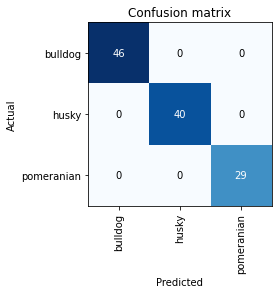

In [20]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

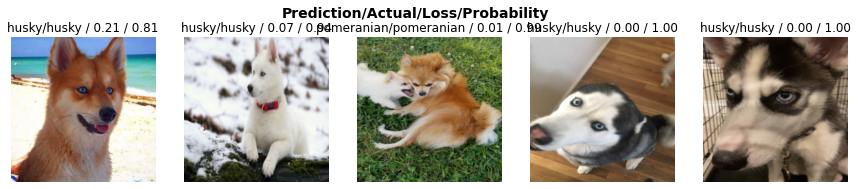

In [21]:
interp.plot_top_losses(5, nrows=1)

The cleaner function below illustrates some of the amazing features that fastai has included in their library. What we can see below is a gui for data cleaning within a cell in our notebook, this makes it incredibly easy to utilise your own model to assist in data cleaning. 

In [22]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [23]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [24]:
#hide
learn.export()

In [25]:
#hide
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [26]:
#hide
learn_inf = load_learner(path/'export.pkl')

In [27]:
#hide
learn_inf.dls.vocab

['bulldog', 'husky', 'pomeranian']

In [28]:
#hide
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [32]:
#hide
img = PILImage.create(btn_upload.data[-1])

In [ ]:
#hide
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

In [34]:
#hide
pred,pred_idx,probs = learn_inf.predict(img)

In [ ]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

In [ ]:
#hide
btn_run = widgets.Button(description='Classify')
btn_run

In [37]:
#hide
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [38]:
#hide
btn_upload = widgets.FileUpload()

In [41]:
VBox([widgets.Label('Select your dog!'), 
      btn_upload, btn_run, out_pl, lbl_pred])